# IBM Coursera Capstone Project: Battle of the Neighborhoods

This notebook will be used to complete the IBM Coursera Chapter 9 Capstone project

## Objective

This report aims to provide expats moving to Singapore with information about the city-state’s neighborhoods so that they can choose a suitable home based on their preferences and budget. We will leverage several data sources about the primary neighborhoods of Singapore to (1) cluster neighborhoods according to what types of venues can be found within, and (2) rank the typical price of housing within each cluster.

### Let's start by importing some key libraries

In [1]:
# Import key Python libraries

import pandas as pd # Library for data analsysis
import numpy as np # Library to handle data in a vectorized manner

from sklearn.impute import SimpleImputer # Helps us address missing data

from bs4 import BeautifulSoup # Library for web scrapping  
import requests # Library to handle requests

from pandas.io.json import json_normalize # Use for tranforming json file into a pandas dataframe library

# Use for cluster analysis
from sklearn.cluster import KMeans 
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Libraries for displaying images
from IPython.display import Image
from IPython.core.display import HTML

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # Helpful for making maps

# Tools for making plots
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

## Datasets

### Import dataset 1: General Information

In [2]:
# Getting data from wikipedia
wikipedia_link='https://en.wikipedia.org/wiki/New_towns_of_Singapore'
raw_wikipedia_page= requests.get(wikipedia_link).text

# Using BeautifulSoup to parse the HTML/XML codes
soup = BeautifulSoup(raw_wikipedia_page,'xml')
soup.prettify(); # this output is very long, so I used the ; to suppress--if you want to see the output, just remove the ;

In [3]:
# Extracting the raw table inside that webpage
table = soup.find_all('table', {'class':'wikitable sortable'})

In [4]:
# Converting the table into a dataframe
df_General_InfoA = pd.read_html(str(table[0]), index_col=None, header=0)[0]
df_General_InfoA.head()

,Name (English/Malay),Chinese,Pinyin,Tamil,Total area (km2),Residential area (km2),Dwelling units,Projected ultimate,Population
0,Ang Mo Kio,宏茂桥,hóngmàoqiáo,ஆங் மோ கியோ,6.38,2.83,49169,58000,149800
1,Bedok,勿洛,wùluò,பிடோ,9.37,4.18,60115,79000,204300
2,Bishan,碧山,bìshān,பீஷான்,6.90,1.72,19664,34000,65700
3,Bukit Batok,武吉巴督,wǔjíbādū,புக்கிட் பாத்தோக்,7.85,2.91,32275,53000,113800
4,Bukit Merah,红山,hóngshān,புக்கிட் மேரா,8.58,3.12,51885,68000,147000


In [5]:
# Read in the second table 
df_General_InfoB = pd.read_html(str(table[1]), index_col=None, header=0)[0]
df_General_InfoB.head()

,Name (English/Malay),Chinese,Pinyin,Tamil,Dwelling units,Population
0,Bukit Timah,武吉知马,–,புக்கித் திமா,2423,88000
1,Marine Parade,马林百列,–,மரின் பரேட்,6537,34300
2,Central Area,新加坡中區,–,சிங்கப்பூர் மாவட்டம்,9459,23300


In [6]:
# Reformat second table so it can be appended to the first
df_General_InfoB.insert(4, "Total area (km2)", np.nan)
df_General_InfoB.insert(5, "Residential area (km2)", np.nan)
df_General_InfoB.insert(7, "Projected ultimate", np.nan)
df_General_InfoB

,Name (English/Malay),Chinese,Pinyin,Tamil,Total area (km2),Residential area (km2),Dwelling units,Projected ultimate,Population
0,Bukit Timah,武吉知马,–,புக்கித் திமா,NaN,NaN,2423,NaN,88000
1,Marine Parade,马林百列,–,மரின் பரேட்,NaN,NaN,6537,NaN,34300
2,Central Area,新加坡中區,–,சிங்கப்பூர் மாவட்டம்,NaN,NaN,9459,NaN,23300


In [7]:
# Combine the two tables into one
df_General_Info = df_General_InfoA.append(df_General_InfoB, ignore_index = True, sort = False)
df_General_Info

,Name (English/Malay),Chinese,Pinyin,Tamil,Total area (km2),Residential area (km2),Dwelling units,Projected ultimate,Population
0,Ang Mo Kio,宏茂桥,hóngmàoqiáo,ஆங் மோ கியோ,6.38,2.83,49169,58000.0,149800
1,Bedok,勿洛,wùluò,பிடோ,9.37,4.18,60115,79000.0,204300
2,Bishan,碧山,bìshān,பீஷான்,6.90,1.72,19664,34000.0,65700
3,Bukit Batok,武吉巴督,wǔjíbādū,புக்கிட் பாத்தோக்,7.85,2.91,32275,53000.0,113800
4,Bukit Merah,红山,hóngshān,புக்கிட் மேரா,8.58,3.12,51885,68000.0,147000
5,Bukit Panjang,武吉班让,wǔjíbānràng,புக்கிட் பாஞ்சாங்,4.89,2.19,34463,44000.0,119300
6,Choa Chu Kang,蔡厝港,càicuògǎng,சுவா சூ காங்,5.83,3.07,42393,62000.0,161100
7,Clementi,金文泰,jīnwéntài,கிளிமெண்டி,4.12,2.03,25480,39000.0,72500
8,Geylang,芽笼,yálóng,கேலாங்,6.78,2.14,29256,49000.0,91900
9,Hougang,后港,hòugǎng,ஹவ்காங்,13.09,3.67,51646,72000.0,179800


### Import dataset 2: Location Data

In [8]:
# Read in dataset
df_Location = pd.read_csv("Data_Locations.csv")

In [9]:
# View the top rows of the dataset
df_Location.head()

,Town,Latitude,Longitude
0,Ang Mo Kio,1.369115,103.845436
1,Bedok,1.323604,103.927338
2,Bishan,1.351197,103.847578
3,Bukit Batok,1.348971,103.749896
4,Bukit Merah,1.281900,103.823900


### Import dataset 3: Home Rental Pricing

In [10]:
# Read in dataset
df_HomePrice = pd.read_csv("Data_Housing.csv")

In [11]:
# View the top rows of the dataset
df_HomePrice.head()

,Town,3-Room,4-Room,5-Room
0,Ang Mo Kio,1700.0,2100.0,2400.0
1,Bedok,1700.0,2000.0,2300.0
2,Bishan,1900.0,2200.0,2500.0
3,Bukit Batok,1600.0,1900.0,2100.0
4,Bukit Merah,1900.0,2500.0,2720.0


#### Address Missing Data

In [12]:
# First, see how many observations are missing
df_HomePrice.isnull().sum().sum()

10

In [13]:
# Next, use mean imputation to replace missing values with the average monthly rent for that size of flat (e.g., 3-Room)
mean_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
mean_imputer = mean_imputer.fit(df_HomePrice[df_HomePrice.columns[1:4]])
HomePrice_clean = mean_imputer.transform(df_HomePrice[df_HomePrice.columns[1:4]])

# Check data
HomePrice_clean

array([[1700.        , 2100.        , 2400.        ],
       [1700.        , 2000.        , 2300.        ],
       [1900.        , 2200.        , 2500.        ],
       [1600.        , 1900.        , 2100.        ],
       [1900.        , 2500.        , 2720.        ],
       [1550.        , 1800.        , 1900.        ],
       [1752.5       , 2090.        , 2243.47826087],
       [2200.        , 2600.        , 2243.47826087],
       [1752.5       , 1800.        , 1900.        ],
       [1800.        , 2350.        , 2600.        ],
       [1800.        , 2300.        , 2500.        ],
       [1650.        , 1950.        , 2100.        ],
       [1700.        , 2000.        , 2300.        ],
       [1600.        , 2000.        , 2150.        ],
       [1900.        , 2400.        , 2600.        ],
       [1800.        , 2050.        , 2243.47826087],
       [1752.5       , 2000.        , 2100.        ],
       [1752.5       , 1900.        , 1900.        ],
       [1900.        , 2650.

In [14]:
# Round imputed values to nearest $10 (to match the rest of the data)
HomePrice_clean = np.round(HomePrice_clean,-1)

# Switch data back to Pandas dataframe
df_HomePrice_clean = pd.DataFrame(HomePrice_clean)

# Add back "Town" field
df_Town = df_HomePrice[["Town"]]
df_HomePrice_clean.insert(0, "Town", df_Town)

# Column names
df_HomePrice_clean.columns = ["Town","3-Room","4-Room","5-Room"]

# Checking
df_HomePrice_clean.head()

,Town,3-Room,4-Room,5-Room
0,Ang Mo Kio,1700.0,2100.0,2400.0
1,Bedok,1700.0,2000.0,2300.0
2,Bishan,1900.0,2200.0,2500.0
3,Bukit Batok,1600.0,1900.0,2100.0
4,Bukit Merah,1900.0,2500.0,2720.0


### Import dataset 4: Venues Nearby

#### Define Foursquare Credentials

In [15]:
# SCRUB BEFORE PUBLISHING

# Write your credentials here
CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret

# Specify Foursquare version
VERSION = '20200816' # in YYYMMDD format

#### Create Function to Extract Venues for each Neighborhood using Foursquare API

In [16]:
# Write function
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=8000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# Use function
df_Nearby_Venues_Raw = getNearbyVenues(names=df_Location['Town'],
                                   latitudes=df_Location['Latitude'],
                                   longitudes=df_Location['Longitude']
                                  )

Ang Mo Kio
Bedok
Bishan
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Central
Choa Chu Kang
Clementi
Geylang
Hougang
Jurong East
Jurong West
Kallang/Whampoa
Marine Parade
Pasir Ris
Punggol
Queenstown
Sembawang
Sengkang
Serangoon
Tampines
Toa Payoh
Woodlands
Yishun


#### Checking the Resulting Dataset

In [18]:
# Shape
df_Nearby_Venues_Raw.shape

(933, 7)

In [19]:
# Number of unique categories of venue
print('There are {} uniques categories.'.format(len(df_Nearby_Venues_Raw['Venue Category'].unique())))

There are 157 uniques categories.


In [20]:
# Number of venues per neighbhorhood
df_Nearby_Venues_Raw.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ang Mo Kio,61,61,61,61,61,61
Bedok,65,65,65,65,65,65
Bishan,44,44,44,44,44,44
Bukit Batok,22,22,22,22,22,22
Bukit Merah,12,12,12,12,12,12
Bukit Panjang,7,7,7,7,7,7
Bukit Timah,2,2,2,2,2,2
Central,87,87,87,87,87,87
Choa Chu Kang,25,25,25,25,25,25


In [21]:
# First 50 rows
df_Nearby_Venues_Raw.head(50)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.369115,103.845436,Kam Jia Zhuang Restaurant,1.368167,103.844118,Asian Restaurant
1,Ang Mo Kio,1.369115,103.845436,Old Chang Kee,1.369094,103.848389,Snack Place
2,Ang Mo Kio,1.369115,103.845436,MOS Burger,1.369170,103.847831,Burger Joint
3,Ang Mo Kio,1.369115,103.845436,FairPrice Xtra,1.369279,103.848886,Supermarket
4,Ang Mo Kio,1.369115,103.845436,NTUC FairPrice,1.371507,103.847082,Supermarket
5,Ang Mo Kio,1.369115,103.845436,Face Ban Mian 非板面 (Ang Mo Kio),1.372031,103.847504,Noodle House
6,Ang Mo Kio,1.369115,103.845436,Dog Run @ Bishan Park,1.365967,103.844024,Dog Run
7,Ang Mo Kio,1.369115,103.845436,PLAYe,1.369109,103.848225,Hobby Shop
8,Ang Mo Kio,1.369115,103.845436,Pepper Lunch,1.369107,103.847791,Japanese Restaurant
9,Ang Mo Kio,1.369115,103.845436,Swensen's,1.369112,103.847718,Dessert Shop


#### Restructing the data using one-hot encoding

- Create 1 feature (column) for each category of venue
- Each venue (row) will receive a 0 or 1 for each new feature, depending on whether that venue falls into the given category or not

In [22]:
# One-hot encoding
df_Nearby_Venues_OneHot = pd.get_dummies(df_Nearby_Venues_Raw[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
df_Nearby_Venues_OneHot['Neighborhood'] = df_Nearby_Venues_Raw['Neighborhood'] 

# Move neighborhood column to the first column
fixed_columns = [df_Nearby_Venues_OneHot.columns[-1]] + list(df_Nearby_Venues_OneHot.columns[:-1])
df_Nearby_Venues_OneHot = df_Nearby_Venues_OneHot[fixed_columns]

# Checking
df_Nearby_Venues_OneHot.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Toy / Game Store,Track Stadium,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wings Joint,Yoga Studio
0,Ang Mo Kio,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ang Mo Kio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Grouping the Data

Currently, one row of the dataset corresponds to one venue, but we want each row to correspond to one neighborhood, with aggregate venue data for the neighborhood. This new dataframe will show each neighborhood along with how many venues it has in each category.

In [23]:
df_Nearby_Venues_Grouped = df_Nearby_Venues_OneHot.groupby('Neighborhood').sum().reset_index()
df_Nearby_Venues_Grouped

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,...,Toy / Game Store,Track Stadium,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wings Joint,Yoga Studio
0,Ang Mo Kio,0,1,0,0,0,2,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,Bedok,0,2,0,0,0,2,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,Bishan,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bukit Batok,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bukit Merah,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Bukit Panjang,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Bukit Timah,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Central,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,2,0,1
8,Choa Chu Kang,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Clementi,0,1,0,0,1,3,0,0,1,...,0,0,0,0,1,0,0,0,0,0


## Exploratory Data Analysis

### Mapping Neighbhorhoods

In [24]:
# Create map of using latitude and longitude values
latitude = 1.3521
longitude = 103.8198
Sing_Map = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add markers to map
for lat, lng, neighborhood in zip(df_Location['Latitude'], df_Location['Longitude'], df_Location['Town']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#e30b0b',
        fill_opacity=0.7,
        parse_html=False).add_to(Sing_Map)  

# Finished map
Sing_Map

### Size (km2) and Population by Neighborhood

Text(0, 0.5, 'Total area (km2)')

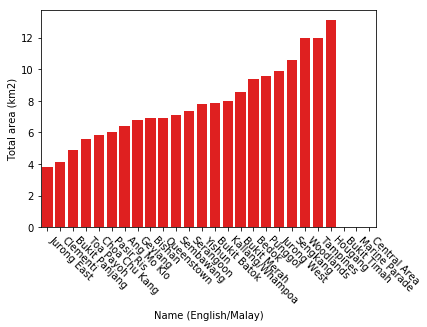

In [25]:
# Univariate stats: Size (km2)
sns.barplot(df_General_Info['Name (English/Malay)'],df_General_Info['Total area (km2)'], color='red', order=df_General_Info.sort_values('Total area (km2)')['Name (English/Malay)'])
plt.xticks(rotation=-45, ha='left')
plt.ylabel('Total area (km2)')

Text(0, 0.5, 'Population')

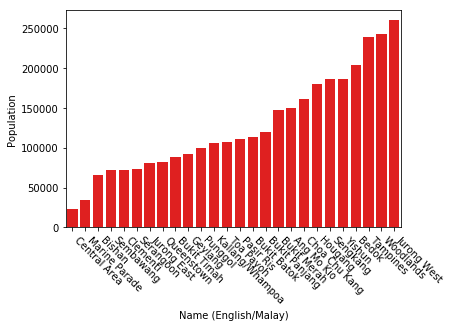

In [26]:
# Univariate stats: Population
sns.barplot(df_General_Info['Name (English/Malay)'],df_General_Info['Population'], color='red', order=df_General_Info.sort_values('Population')['Name (English/Malay)'])
plt.xticks(rotation=-45, ha='left')
plt.ylabel('Population')

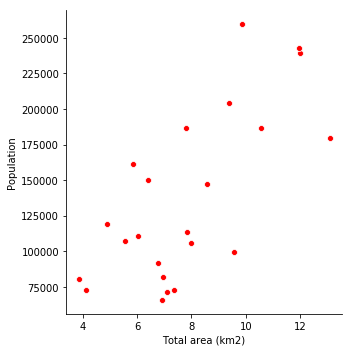

In [27]:
# Scatterplot: Size (km2) x Population
sns.relplot(x='Total area (km2)', y='Population', color="red", data=df_General_Info)

Text(0, 0.5, 'Population Density (Population / Total Area)')

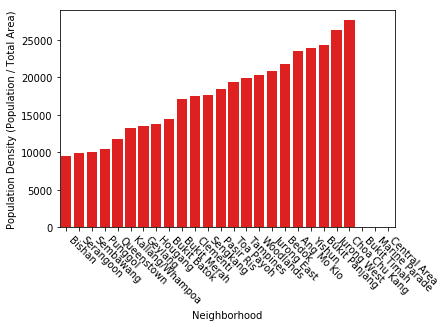

In [28]:
# Univariate stats: population density (population / total area)

# Create population density dataset
Pop_Density = df_General_Info['Population'] / df_General_Info['Total area (km2)']
df_Pop_Density = pd.DataFrame(Pop_Density)
df_Town = df_General_Info[["Name (English/Malay)"]]
df_Pop_Density.insert(0, "Neighborhood", df_Town)
df_Pop_Density.columns = ["Neighborhood","Population Density"]

# Graph
sns.barplot(df_Pop_Density['Neighborhood'],df_Pop_Density['Population Density'], color='red', order=df_Pop_Density.sort_values('Population Density')['Neighborhood'])
plt.xticks(rotation=-45, ha='left')
plt.ylabel('Population Density (Population / Total Area)')

### Most Common Venue Types, by Neighborhood

In [29]:
# Create function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_Nearby_Venues_Sorted = pd.DataFrame(columns=columns)
df_Nearby_Venues_Sorted['Neighborhood'] = df_Nearby_Venues_Grouped['Neighborhood']

for ind in np.arange(df_Nearby_Venues_Grouped.shape[0]):
    df_Nearby_Venues_Sorted.iloc[ind, 1:] = return_most_common_venues(df_Nearby_Venues_Grouped.iloc[ind, :], num_top_venues)

df_Nearby_Venues_Sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ang Mo Kio,Food Court,Coffee Shop,Fast Food Restaurant,Dessert Shop,Supermarket,Bubble Tea Shop,Japanese Restaurant,Snack Place,Sandwich Place,Asian Restaurant
1,Bedok,Café,Chinese Restaurant,Sushi Restaurant,Food Court,Coffee Shop,Supermarket,Bakery,Garden Center,Japanese Restaurant,Malay Restaurant
2,Bishan,Food Court,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop,Ice Cream Shop,Japanese Restaurant,Asian Restaurant,Cosmetics Shop,Supermarket
3,Bukit Batok,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Food Court,Department Store,Basketball Court,Sandwich Place,Café,Multiplex,Shopping Mall
4,Bukit Merah,Chinese Restaurant,Furniture / Home Store,Convenience Store,Asian Restaurant,Coffee Shop,Japanese Restaurant,Residential Building (Apartment / Condo),Seafood Restaurant,Gym,Fish & Chips Shop
5,Bukit Panjang,Food Court,Park,Miscellaneous Shop,Market,Noodle House,Yoga Studio,Flower Shop,French Restaurant,Food Truck,Food & Drink Shop
6,Bukit Timah,Pool,Gym,Yoga Studio,Flower Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food
7,Central,Japanese Restaurant,Coffee Shop,Café,Sandwich Place,Chinese Restaurant,Gym / Fitness Center,Bar,Hotel,Mexican Restaurant,Bakery
8,Choa Chu Kang,Coffee Shop,Noodle House,Fast Food Restaurant,Accessories Store,Shoe Store,Sandwich Place,Café,Snack Place,Bubble Tea Shop,Bookstore
9,Clementi,Coffee Shop,Food Court,Dessert Shop,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Noodle House,Dim Sum Restaurant,Electronics Store,Fast Food Restaurant


In [33]:
# Frequency of "1st Most Common Venue"
df_Nearby_Venues_Sorted["1st Most Common Venue"].value_counts()

Food Court              5
Coffee Shop             5
Japanese Restaurant     4
Chinese Restaurant      4
Grocery Store           1
Restaurant              1
Bakery                  1
Supermarket             1
Fast Food Restaurant    1
Pool                    1
Park                    1
Café                    1
Name: 1st Most Common Venue, dtype: int64

## K-Means Clustering

### Prep Data

In [31]:
# Data for clustering
Sing_Cluster_Data = df_Nearby_Venues_Grouped.drop('Neighborhood', 1)
Sing_Cluster_Data.head()

,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,...,Toy / Game Store,Track Stadium,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wings Joint,Yoga Studio
0,0,1,0,0,0,2,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,2,0,0,0,2,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Determining K using the "elbow method"

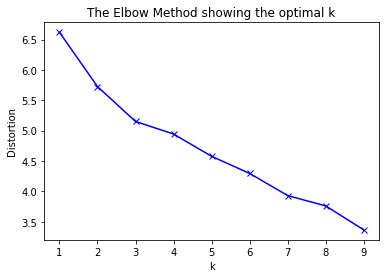

In [32]:
# K-means determine k
distortions = []
K = range(1,10)
for k in K:
    ChooseKModel = KMeans(n_clusters=k).fit(Sing_Cluster_Data)
    ChooseKModel.fit(Sing_Cluster_Data)
    distortions.append(sum(np.min(cdist(Sing_Cluster_Data, ChooseKModel.cluster_centers_, 'euclidean'), axis=1)) / Sing_Cluster_Data.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Clustering Neighborhoods

In [34]:
# Set number of clusters
kclusters = 4

# Run k-means clustering
ClusterModel = KMeans(n_clusters=kclusters, random_state=0).fit(Sing_Cluster_Data)

# Check cluster labels generated for each row in the dataframe
ClusterModel.labels_[0:27]

array([2, 0, 2, 2, 1, 1, 1, 3, 2, 2, 2, 2, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1,
       0, 2, 0, 2], dtype=int32)

### Create Dataset Based on Clustering Results, Combining:
- Neighborhood Names
- Coordinates (Lat / Long)
- Cluster Label
- Top 10 Common Venues

In [35]:
# Add clustering labels to "Most Common Venue Types, by Neighborhood" dataset
df_Nearby_Venues_Sorted.insert(0, 'Cluster Labels', ClusterModel.labels_)

# Prep Location dataset
df_Neighborhoods_Merged = df_Location

# Merge venue data with latitude/longitude for each neighborhood
df_Neighborhoods_Merged = df_Neighborhoods_Merged.join(df_Nearby_Venues_Sorted.set_index('Neighborhood'), on='Town')

# Merge data with home rental pricing 
df_Neighborhoods_Merged = df_Neighborhoods_Merged.join(df_HomePrice_clean.set_index('Town'), on='Town')

In [36]:
# Examine results
df_Neighborhoods_Merged

,Town,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,3-Room,4-Room,5-Room
0,Ang Mo Kio,1.369115,103.845436,2,Food Court,Coffee Shop,Fast Food Restaurant,Dessert Shop,Supermarket,Bubble Tea Shop,Japanese Restaurant,Snack Place,Sandwich Place,Asian Restaurant,1700.0,2100.0,2400.0
1,Bedok,1.323604,103.927338,0,Café,Chinese Restaurant,Sushi Restaurant,Food Court,Coffee Shop,Supermarket,Bakery,Garden Center,Japanese Restaurant,Malay Restaurant,1700.0,2000.0,2300.0
2,Bishan,1.351197,103.847578,2,Food Court,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop,Ice Cream Shop,Japanese Restaurant,Asian Restaurant,Cosmetics Shop,Supermarket,1900.0,2200.0,2500.0
3,Bukit Batok,1.348971,103.749896,2,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Food Court,Department Store,Basketball Court,Sandwich Place,Café,Multiplex,Shopping Mall,1600.0,1900.0,2100.0
4,Bukit Merah,1.281900,103.823900,1,Chinese Restaurant,Furniture / Home Store,Convenience Store,Asian Restaurant,Coffee Shop,Japanese Restaurant,Residential Building (Apartment / Condo),Seafood Restaurant,Gym,Fish & Chips Shop,1900.0,2500.0,2720.0
5,Bukit Panjang,1.377400,103.771900,1,Food Court,Park,Miscellaneous Shop,Market,Noodle House,Yoga Studio,Flower Shop,French Restaurant,Food Truck,Food & Drink Shop,1550.0,1800.0,1900.0
6,Bukit Timah,1.329400,103.802100,1,Pool,Gym,Yoga Studio,Flower Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,1750.0,2090.0,2240.0
7,Central,1.278900,103.853600,3,Japanese Restaurant,Coffee Shop,Café,Sandwich Place,Chinese Restaurant,Gym / Fitness Center,Bar,Hotel,Mexican Restaurant,Bakery,2200.0,2600.0,2240.0
8,Choa Chu Kang,1.384000,103.747000,2,Coffee Shop,Noodle House,Fast Food Restaurant,Accessories Store,Shoe Store,Sandwich Place,Café,Snack Place,Bubble Tea Shop,Bookstore,1750.0,1800.0,1900.0
9,Clementi,1.316116,103.764816,2,Coffee Shop,Food Court,Dessert Shop,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Noodle House,Dim Sum Restaurant,Electronics Store,Fast Food Restaurant,1800.0,2350.0,2600.0


### Mapping Clusters

In [37]:
# Create map
latitude = 1.3521
longitude = 103.8198
Map_Clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1.2, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_Neighborhoods_Merged['Latitude'], df_Neighborhoods_Merged['Longitude'], df_Neighborhoods_Merged['Town'], df_Neighborhoods_Merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(Map_Clusters)
       
Map_Clusters

### Examining Each Cluster

In [38]:
# Cluster 0
df_Cluster_zero = df_Neighborhoods_Merged[df_Neighborhoods_Merged['Cluster Labels'] == 0]
df_Cluster_zero

,Town,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,3-Room,4-Room,5-Room
1,Bedok,1.323604,103.927338,0,Café,Chinese Restaurant,Sushi Restaurant,Food Court,Coffee Shop,Supermarket,Bakery,Garden Center,Japanese Restaurant,Malay Restaurant,1700.0,2000.0,2300.0
12,Jurong East,1.332900,103.743600,0,Japanese Restaurant,Chinese Restaurant,Café,Shopping Mall,Coffee Shop,Food Court,Bubble Tea Shop,Clothing Store,Korean Restaurant,Sushi Restaurant,1700.0,2000.0,2300.0
13,Jurong West,1.340400,103.709000,0,Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Dessert Shop,Coffee Shop,Indian Restaurant,Café,Seafood Restaurant,Sporting Goods Shop,1600.0,2000.0,2150.0
22,Tampines,1.353718,103.942009,0,Bakery,Indian Restaurant,Coffee Shop,Café,Sushi Restaurant,Chinese Restaurant,Gym,Fast Food Restaurant,Dessert Shop,Thai Restaurant,1750.0,2100.0,2250.0
24,Woodlands,1.438200,103.789000,0,Japanese Restaurant,Chinese Restaurant,Café,Food Court,Shopping Mall,Coffee Shop,Electronics Store,Frozen Yogurt Shop,Bus Station,Snack Place,1400.0,1750.0,1800.0


In [39]:
# Cluster 1
df_Cluster_one = df_Neighborhoods_Merged[df_Neighborhoods_Merged['Cluster Labels'] == 1]
df_Cluster_one

,Town,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,3-Room,4-Room,5-Room
4,Bukit Merah,1.281900,103.823900,1,Chinese Restaurant,Furniture / Home Store,Convenience Store,Asian Restaurant,Coffee Shop,Japanese Restaurant,Residential Building (Apartment / Condo),Seafood Restaurant,Gym,Fish & Chips Shop,1900.0,2500.0,2720.0
5,Bukit Panjang,1.377400,103.771900,1,Food Court,Park,Miscellaneous Shop,Market,Noodle House,Yoga Studio,Flower Shop,French Restaurant,Food Truck,Food & Drink Shop,1550.0,1800.0,1900.0
6,Bukit Timah,1.329400,103.802100,1,Pool,Gym,Yoga Studio,Flower Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,1750.0,2090.0,2240.0
14,Kallang/Whampoa,1.310000,103.865100,1,Restaurant,Coffee Shop,BBQ Joint,Fast Food Restaurant,Supermarket,Hostel,Metro Station,Asian Restaurant,Food Court,Nightclub,1900.0,2400.0,2600.0
15,Marine Parade,1.302046,103.896999,1,Chinese Restaurant,Bar,Ice Cream Shop,Bakery,Flower Shop,Food,Café,Food Court,Steakhouse,Supermarket,1800.0,2050.0,2240.0
17,Punggol,1.398400,103.907200,1,Chinese Restaurant,Indian Restaurant,Music Venue,Bus Station,Bus Stop,Café,High School,Bagel Shop,Basketball Court,Yoga Studio,1750.0,1900.0,1900.0
18,Queenstown,1.298129,103.799471,1,Chinese Restaurant,Noodle House,Vegetarian / Vegan Restaurant,Asian Restaurant,Bakery,Ice Cream Shop,Stadium,Pool,Convenience Store,Food & Drink Shop,1900.0,2650.0,2800.0
19,Sembawang,1.449100,103.818500,1,Supermarket,Coffee Shop,Fast Food Restaurant,Shopping Mall,Convenience Store,Food Court,Japanese Restaurant,Sporting Goods Shop,Chinese Restaurant,Government Building,1750.0,1800.0,1900.0
20,Sengkang,1.386800,103.891400,1,Grocery Store,Gym,Coffee Shop,Metro Station,Basketball Court,Yoga Studio,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,1750.0,1900.0,1950.0
21,Serangoon,1.355400,103.867900,1,Park,Asian Restaurant,Smoke Shop,Indonesian Restaurant,Trail,Track Stadium,Bus Station,Auto Garage,Fast Food Restaurant,Bakery,1800.0,2200.0,2300.0


In [40]:
# Cluster 2
df_Cluster_two = df_Neighborhoods_Merged[df_Neighborhoods_Merged['Cluster Labels'] == 2]
df_Cluster_two

,Town,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,3-Room,4-Room,5-Room
0,Ang Mo Kio,1.369115,103.845436,2,Food Court,Coffee Shop,Fast Food Restaurant,Dessert Shop,Supermarket,Bubble Tea Shop,Japanese Restaurant,Snack Place,Sandwich Place,Asian Restaurant,1700.0,2100.0,2400.0
2,Bishan,1.351197,103.847578,2,Food Court,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop,Ice Cream Shop,Japanese Restaurant,Asian Restaurant,Cosmetics Shop,Supermarket,1900.0,2200.0,2500.0
3,Bukit Batok,1.348971,103.749896,2,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Food Court,Department Store,Basketball Court,Sandwich Place,Café,Multiplex,Shopping Mall,1600.0,1900.0,2100.0
8,Choa Chu Kang,1.384000,103.747000,2,Coffee Shop,Noodle House,Fast Food Restaurant,Accessories Store,Shoe Store,Sandwich Place,Café,Snack Place,Bubble Tea Shop,Bookstore,1750.0,1800.0,1900.0
9,Clementi,1.316116,103.764816,2,Coffee Shop,Food Court,Dessert Shop,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Noodle House,Dim Sum Restaurant,Electronics Store,Fast Food Restaurant,1800.0,2350.0,2600.0
10,Geylang,1.320100,103.891800,2,Fast Food Restaurant,Shopping Mall,Bakery,Asian Restaurant,Supermarket,Food Court,Bubble Tea Shop,Steakhouse,Ramen Restaurant,Gym,1800.0,2300.0,2500.0
11,Hougang,1.371802,103.891619,2,Coffee Shop,Fast Food Restaurant,Supermarket,Food Court,Café,Shopping Mall,Chinese Restaurant,Bus Station,Gym,Bookstore,1650.0,1950.0,2100.0
16,Pasir Ris,1.372100,103.947400,2,Food Court,Japanese Restaurant,Coffee Shop,Sandwich Place,Bakery,Bus Station,Supermarket,Restaurant,Diner,Bus Stop,1750.0,2000.0,2100.0
23,Toa Payoh,1.331835,103.850177,2,Coffee Shop,Snack Place,Pool,Chinese Restaurant,Food Court,Supermarket,Park,Dessert Shop,Fast Food Restaurant,Residential Building (Apartment / Condo),1800.0,2200.0,2500.0
25,Yishun,1.430400,103.835400,2,Food Court,Italian Restaurant,Chinese Restaurant,Fried Chicken Joint,Hainan Restaurant,Pharmacy,Coffee Shop,Fast Food Restaurant,Supermarket,Restaurant,1600.0,1800.0,2030.0


In [41]:
# Cluster 3
df_Cluster_three = df_Neighborhoods_Merged[df_Neighborhoods_Merged['Cluster Labels'] == 3]
df_Cluster_three

,Town,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,3-Room,4-Room,5-Room
7,Central,1.2789,103.8536,3,Japanese Restaurant,Coffee Shop,Café,Sandwich Place,Chinese Restaurant,Gym / Fitness Center,Bar,Hotel,Mexican Restaurant,Bakery,2200.0,2600.0,2240.0


## Home Rental Price Ranking

### Rank Prices within Clusters (4-room flat)

In [42]:
# Print neighborhoods in cluster 0, cheapest to most expensive
df_Cluster_zero.sort_values(["4-Room"]).Town

24      Woodlands
1           Bedok
12    Jurong East
13    Jurong West
22       Tampines
Name: Town, dtype: object

In [43]:
# Print neighborhoods in cluster 1, cheapest to most expensive
df_Cluster_one.sort_values(["4-Room"]).Town

5       Bukit Panjang
19          Sembawang
17            Punggol
20           Sengkang
15      Marine Parade
6         Bukit Timah
21          Serangoon
14    Kallang/Whampoa
4         Bukit Merah
18         Queenstown
Name: Town, dtype: object

In [44]:
# Print neighborhoods in cluster 2, cheapest to most expensive
df_Cluster_two.sort_values(["4-Room"]).Town

8     Choa Chu Kang
25           Yishun
3       Bukit Batok
11          Hougang
16        Pasir Ris
0        Ang Mo Kio
2            Bishan
23        Toa Payoh
10          Geylang
9          Clementi
Name: Town, dtype: object

In [45]:
# Print neighborhoods in cluster 3, cheapest to most expensive
df_Cluster_three.sort_values(["4-Room"]).Town

7    Central
Name: Town, dtype: object

### Calculate Mean Rent for Each Cluster (4-room flat)

In [46]:
# Mean rent price, cluster 0
df_Cluster_zero["4-Room"].mean()

1970.0

In [47]:
# Mean rent price, cluster 1
df_Cluster_one["4-Room"].mean()

2129.0

In [48]:
# Mean rent price, cluster 2
df_Cluster_two["4-Room"].mean()

2060.0

In [49]:
# Mean rent price, cluster 3
df_Cluster_three["4-Room"].mean()

2600.0

### Graph Median Rent for Each Neighborhood, within Clusters (4-room flat)

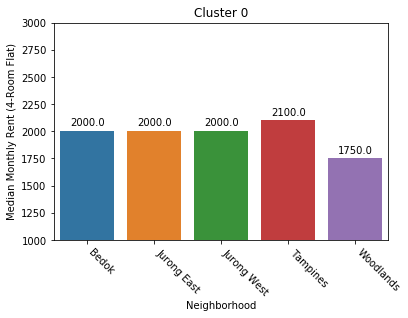

In [53]:
# Rent prices for each neighborhood, Cluster 0
sns.barplot(x="Town", y="4-Room", data=df_Cluster_zero)
plt.title("Cluster 0")
plt.ylim(1000,3000)
plt.ylabel("Median Monthly Rent (4-Room Flat)")
plt.xlabel("Neighborhood")
plt.xticks(rotation=-45, ha='left')
y = np.array(df_Cluster_zero["4-Room"])
xlocs, _ = plt.xticks()
for i, v in enumerate(y):
    plt.text(xlocs[i]-0.25, v+50, str(np.around(v,1)))

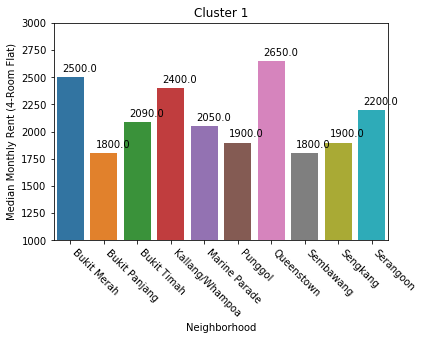

In [52]:
# Rent prices for each neighborhood, Cluster 1
sns.barplot(x="Town", y="4-Room", data=df_Cluster_one)
plt.title("Cluster 1")
plt.ylim(1000,3000)
plt.ylabel("Median Monthly Rent (4-Room Flat)")
plt.xlabel("Neighborhood")
plt.xticks(rotation=-45, ha='left')
y = np.array(df_Cluster_one["4-Room"])
xlocs, _ = plt.xticks()
for i, v in enumerate(y):
    plt.text(xlocs[i]-0.25, v+50, str(np.around(v,1)))

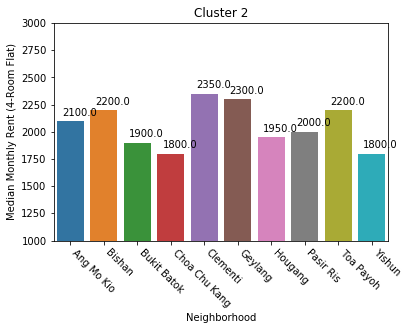

In [54]:
# Rent prices for each neighborhood, Cluster 2
sns.barplot(x="Town", y="4-Room", data=df_Cluster_two)
plt.title("Cluster 2")
plt.ylim(1000,3000)
plt.ylabel("Median Monthly Rent (4-Room Flat)")
plt.xlabel("Neighborhood")
plt.xticks(rotation=-45, ha='left')
y = np.array(df_Cluster_two["4-Room"])
xlocs, _ = plt.xticks()
for i, v in enumerate(y):
    plt.text(xlocs[i]-0.25, v+50, str(np.around(v,1)))

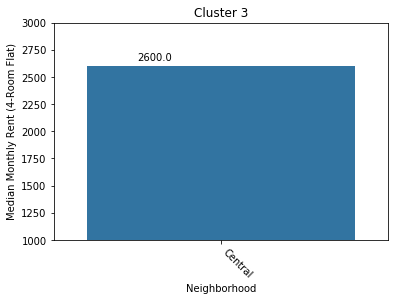

In [55]:
# Rent prices for each neighborhood, Cluster 3
sns.barplot(x="Town", y="4-Room", data=df_Cluster_three)
plt.title("Cluster 3")
plt.ylim(1000,3000)
plt.ylabel("Median Monthly Rent (4-Room Flat)")
plt.xlabel("Neighborhood")
plt.xticks(rotation=-45, ha='left')
y = np.array(df_Cluster_three["4-Room"])
xlocs, _ = plt.xticks()
for i, v in enumerate(y):
    plt.text(xlocs[i]-0.25, v+50, str(np.around(v,1)))

## Conclusion

In this notebook we imported data from four sources, including using Foursquare API, to examine neighborhoods of Singapore. We performed a cluster analysis to group the 26 neighborhoods into clusters, examined and mapped each cluster, and evaluated home rental pricing within clusters.